In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

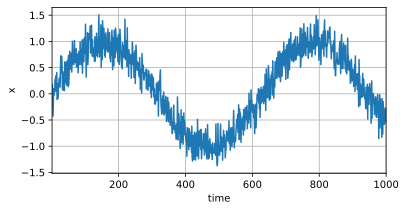

In [2]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [14]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    #features = [self.x[t:t+self.tau] for t in range(T-self.tau)]
    features = [self.x[i:self.T-self.tau+i] for i in range(self.tau)]
    self.features = torch.stack(features, dim=1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels],
                                 train, i)

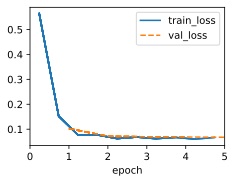

In [15]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

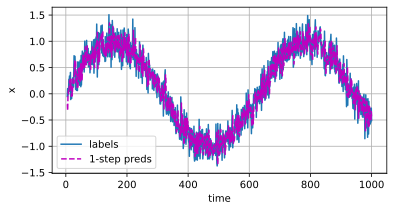

In [17]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

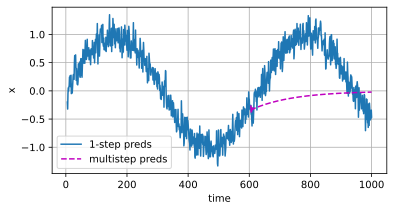

In [18]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

[tensor([-0.1887, -0.1376,  0.0044,  0.0097,  0.0182,  0.0391,  0.1093,  0.1474,
         0.1781,  0.1119,  0.0537,  0.1648,  0.0749, -0.0168,  0.0642,  0.0202,
         0.0038,  0.0701,  0.1360,  0.1807,  0.1824,  0.1267,  0.2025,  0.3757,
         0.3421,  0.2669,  0.3645,  0.3753,  0.1867,  0.1845,  0.2553,  0.1421,
         0.0981,  0.0955,  0.0563,  0.2238,  0.2348,  0.2430,  0.2712,  0.3178,
         0.2563,  0.1380,  0.2285,  0.3599,  0.3272,  0.1788,  0.2965,  0.2590,
         0.1963,  0.3372,  0.4636,  0.4249,  0.3330,  0.3337,  0.4265,  0.4519,
         0.3451,  0.3750,  0.5444,  0.5168,  0.4155,  0.3759,  0.3590,  0.4223,
         0.5634,  0.5280,  0.4195,  0.4076,  0.3961,  0.4712,  0.4258,  0.3766,
         0.4248,  0.4648,  0.4499,  0.3383,  0.3476,  0.4601,  0.4527,  0.4284,
         0.3949,  0.5065,  0.5274,  0.4605,  0.5014,  0.4392,  0.3890,  0.5354,
         0.4302,  0.3850,  0.4287,  0.5430,  0.5088,  0.4780,  0.5953,  0.6697,
         0.5853,  0.6906,  0.6980,  0.4

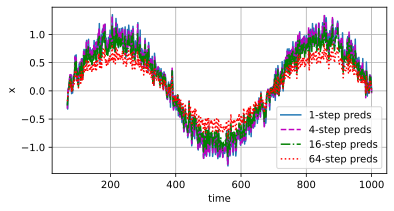

In [32]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].detach().numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

In [28]:
preds[63].shape

torch.Size([933])

In [23]:
torch.stack(features[63 : 63+data.tau], 1)

RuntimeError: stack expects a non-empty TensorList